# Prepare 1000 Genome Reference dataset with full data
WARNING: NEEDS 60GB OF RAM

UPDATED September 21 to include saving of the X chromosome

In [1]:
import allel
import h5py  # Python Package to do the HDF5.
import numpy as np
import pandas as pd
import socket
import os as os
import sys as sys
import multiprocessing as mp
import matplotlib.pyplot as plt

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)
#sys.path.append("./Python3/")  # Since now we are in the Root Directory

print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

sys.path.insert(0,"./package/")  # hack to get local package first in path
from hapsburg.PackagesSupport.h5_python.h5_functions import merge_in_ld_map, save_data_h5

midway2-0402.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


### Helper Function

In [2]:
def filter_vcf_to_biallelic(in_path, out_path):
    """Filters .vcf File to biallelic SNPs"""
    !bcftools view -Oz -o $out_path -m2 -M2 -v snps $in_path 
    print("Finished BCF tools filtering to biallelic variants.")

def vcf_to_hdf5(in_path, out_path, path_vcf100g=""):
    """Transform Full VCF to full HDF5"""
    allel.vcf_to_hdf5(input=in_path, output=out_path, compression="gzip") # Takes 10 Minutes ####chunk_length=1000000, chunk_width=1, garbage performance
    
def download_1kg(path_source="", path_target=""):
    """cluster: Whether program is run on cluster"""
    tbi_s = path_source + ".tbi"
    tbi_t = path_target + ".tbi"
    
    !scp $path_source $path_target # Only Download the .vcf (not the .tbi)
    !scp $tbi_s $tbi_t             # Download the tbi
    print(f"Transfer complete. To {path_target}")
    
def downsample_af(path_h5, path_save, maf=0.002, batch=1000000):
    """Loads hdf5 at path_h5, and filters to loci >maf.
    Save h5 at path_save. Assumes everything is in standard format"""

    f = h5py.File(path_h5, "r") # Load for Sanity Check. See below!

    ### Calculate the AFs
    k = np.shape(f["calldata/GT"])[0]
    
    idcs = [] # the list of list of idx in each batch
    ### Work in batches
    for i in range(int(k/batch)+1):
        print(f"Doing batch {i}...")
        gt = f["calldata/GT"][i*batch:(i+1)*batch,:,:]  
        n = np.shape(gt)[1]*2 # number of haplotypes
        gt = np.sum(gt==0, axis=1)
        gt = np.sum(gt, axis=1)
        p_der = 1 - gt/n
        idx = p_der > maf # Filter
        idcs.append(idx)
        
    idx = np.concatenate(idcs)
    print(f"Downsampling to {np.sum(idx)}/{len(idx)} Markers with MAF >{maf}")

    gt = f["calldata/GT"][:,:,:][idx] # Extract the Ind
    ref=f["variants/REF"][:][idx]
    alt=f["variants/ALT"][:][idx,0] # only save the first alt allele
    pos=f["variants/POS"][:][idx]
    rec=f["variants/MAP"][:][idx]
    samples=f["samples"][:]
    f.close()
    
    print("Saving new HDF...")
    save_data_h5(gt=gt, ad=[],
                 ref=ref, alt=alt,
                 pos=pos, rec=rec,
                 samples=samples,
                 path=path_save,
                 compression='gzip',
                 ad_group=False, gt_type='int8')

### Master Function piping together everything

In [3]:
ch = "X" # Will fill in X for Chromosome Numbers
path_vcf_source = f"/project2/jnovembre/data/external_public/1kg_phase3/haps/ALL.chr{ch}.phase3_shapeit2_mvncall_integrated_v1b.20130502.genotypes.vcf.gz"
path_vcf_here = f"./Data/1000Genomes/AutosomeVCF/Full/chr{ch}.vcf.gz"
path_vcf_filter = f"./Data/1000Genomes/AutosomeVCF/SNPs/chr{ch}.vcf.gz"
path_h5 = f"./Data/1000Genomes/HDF5/FULLHDF5/chr{ch}.hdf5"
path_h5_maf = f"./Data/1000Genomes/HDF5/FULLHDF5/maf02_chr{ch}.hdf5"
path_snp1240k = "./Data/1000Genomes/Markers/MinMyc.snp"

In [7]:
### The functions of the pipeline
download_1kg(path_vcf_source, path_vcf_here)  ## Takes about 20 seconds

Transfer complete. To ./Data/1000Genomes/AutosomeVCF/Full/chrX.vcf.gz


In [46]:
%%time
filter_vcf_to_biallelic(in_path=path_vcf_here, out_path=path_vcf_filter)  ## Takes about 30 Minutes

Finished BCF tools filtering to biallelic variants.
CPU times: user 22.1 s, sys: 4.87 s, total: 26.9 s
Wall time: 26min 38s


In [47]:
%%time
vcf_to_hdf5(path_vcf_filter, path_h5)            ## Takes about 10 for long Chromosome

CPU times: user 9min 13s, sys: 27.2 s, total: 9min 40s
Wall time: 9min 41s


In [48]:
### Change the Chromosome Number from X to 23.
# Takes ca. 
with h5py.File(path_h5, 'r+') as f:     # open the file
    data = f['variants/CHROM']       # load the data
    data[:] = str(23)                      # assign new values to data
    f.close()   

In [6]:
%%time
merge_in_ld_map(path_h5=path_h5, path_snp1240k=path_snp1240k, chs=[23,], write_mode="a")  
## Takes about 10 seconds, mode a for new LD Map; r+ for changing

Lifting LD Map from eigenstrat to HDF5...
Loaded 3223936 variants.
Loaded 2504 individuals.
Loaded 49704 Chr.23 1240K SNPs.
Intersection 47897 out of 3223936 HDF5 SNPs
Interpolating 3176039 variants.
Finished Chromosome 23.
Adding map to HDF5...
We did it. Finished.
CPU times: user 10.3 s, sys: 803 ms, total: 11.1 s
Wall time: 14.4 s


In [7]:
%%time
downsample_af(path_h5, path_h5_maf, maf=0.01) ## Takes about 10 Minute, mode a for new LD Map

Doing batch 0...
Doing batch 1...
Doing batch 2...
Doing batch 3...
Downsampling to 3143608/3223936 Markers with MAF >0.01
Saving new HDF...
Successfully saved 2504 individuals to: ./Data/1000Genomes/HDF5/FULLHDF5/maf02_chrX.hdf5
CPU times: user 7min 22s, sys: 35.4 s, total: 7min 58s
Wall time: 8min 3s


# Do the full Run

### Downsample to AF SNPs

# Area 51

In [6]:
### Test the Final HDF5 just created
ch = 3
path_load = f"./Data/1000Genomes/HDF5/FULLHDF5/maf1_chrX.hdf5"

f = h5py.File(path_load, "r") # Load for Sanity Check. See below!
print("Loaded %i variants" % np.shape(f["calldata/GT"])[0])
print("Loaded %i individuals" % np.shape(f["calldata/GT"])[1])
print(list(f["calldata"].keys()))
print(list(f["variants"].keys()))

Loaded 3143608 variants
Loaded 2504 individuals
['GT']
['ALT', 'MAP', 'POS', 'REF']


In [6]:
f["samples"][:].astype("str")=="iid0"

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

# Test loading the new hdf5 file

In [9]:
### Test the Final HDF5 just created
ch = "X"
path_load = f"./Data/1000Genomes/HDF5/FULLHDF5/maf1_chrX.hdf5" # /maf02_chrX.hdf5

f = h5py.File(path_load, "r") # Load for Sanity Check. See below!
print("Loaded %i variants" % np.shape(f["calldata/GT"])[0])
print("Loaded %i individuals" % np.shape(f["calldata/GT"])[1])
print(list(f["calldata"].keys()))
print(list(f["variants"].keys()))

Loaded 3143608 variants
Loaded 2504 individuals
['GT']
['ALT', 'MAP', 'POS', 'REF']


In [12]:
gt = f["calldata/GT"]

In [15]:
pd.value_counts(gt[:100,:100,:].flatten())

0    17395
1     2605
dtype: int64

In [10]:
pos = f["variants/MAP"]
np.shape(pos)

(3143608,)

In [11]:
pos[2000000:2000000+100]

array([1.2363635, 1.2363635, 1.2363636, 1.2363636, 1.2363639, 1.2363639,
       1.2363639, 1.236364 , 1.236364 , 1.2363641, 1.2363641, 1.2363642,
       1.2363644, 1.2363645, 1.2363645, 1.2363647, 1.2363647, 1.2363647,
       1.2363648, 1.236365 , 1.236365 , 1.2363652, 1.2363654, 1.2363656,
       1.2363658, 1.2363658, 1.2363658, 1.2363662, 1.2363664, 1.2363665,
       1.2363665, 1.2363667, 1.2363667, 1.2363669, 1.236367 , 1.236367 ,
       1.236367 , 1.2363671, 1.2363672, 1.2363672, 1.2363673, 1.2363673,
       1.2363675, 1.2363675, 1.2363676, 1.2363676, 1.2363678, 1.236368 ,
       1.236368 , 1.236368 , 1.2363681, 1.2363682, 1.2363687, 1.2363689,
       1.236369 , 1.2363691, 1.2363691, 1.2363695, 1.2363695, 1.2363696,
       1.23637  , 1.2363701, 1.2363702, 1.2363702, 1.2363703, 1.2363703,
       1.2363704, 1.2363706, 1.2363706, 1.2363707, 1.2363708, 1.2363708,
       1.2363709, 1.236371 , 1.236371 , 1.2363713, 1.236372 , 1.236372 ,
       1.2363725, 1.2363727, 1.2363734, 1.2363734, 

In [15]:
f.close()

# Do experiments about loading time of data

In [52]:
from time import time

In [ ]:
%%time
res = []
s = np.shape(f["calldata/GT"])
ts = [10,50,100,500,1000, 5000, 10000, 50000, 100000]

for i in ts:
    print(f"Doing {i} Loci")
    t = time() 
    idx = np.random.choice(s[0], size=i, replace=False)
    idx=  np.sort(idx)
    gt = f["calldata/GT"][idx,:,:]
    e = time()
    res.append(e-t)

# Allele Frequency Spectrum

In [37]:
%%time
### Test the Final HDF5 just created
path_load = f"./Data/1000Genomes/HDF5/FULLHDF5/chrX.hdf5" # /maf02_chrX.hdf5

f = h5py.File(path_load, "r") # Load for Sanity Check. See below!
print("Loaded %i variants" % np.shape(f["calldata/GT"])[0])
print("Loaded %i individuals" % np.shape(f["calldata/GT"])[1])
print(list(f["calldata"].keys()))
print(list(f["variants"].keys()))

gt = f["calldata/GT"][:,:,:]

Loaded 3223936 variants
Loaded 2504 individuals
['GT']
['ALT', 'CHROM', 'FILTER_PASS', 'ID', 'MAP', 'POS', 'QUAL', 'REF']
CPU times: user 45.5 s, sys: 10.5 s, total: 56.1 s
Wall time: 57.4 s


In [17]:
gt1 = np.sum(gt==0, axis=1)
gt2 = np.sum(gt1, axis=1)
p_der = 1 - gt2/(np.shape(gt)[1]*2)

In [35]:
np.shape(gt)

(3143608, 2504, 2)

In [38]:
pd.value_counts(gt[:,:100,:].flatten())

 0    476559356
-1    156060650
 1     12167194
dtype: int64

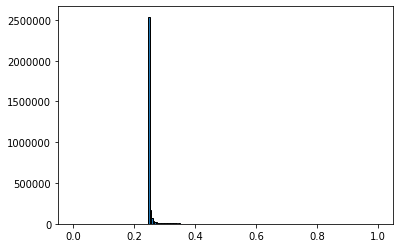

In [34]:
bins = np.linspace(0, 1, 201)

plt.figure()
ax = plt.gca()
ax.hist(p_der, ec="k", bins=bins)
plt.show()

In [ ]:
f["variants/ALT"][:100]

In [6]:
f.close()

NameError: name 'f' is not defined

### Try loading 1e6 genotypes - check how much data is needed

In [8]:
a = 1

In [9]:
print(psutil.virtual_memory().used / (1024.0 ** 3))
print(psutil.virtual_memory().total / (1024.0 ** 3))

5.534832000732422
62.49126052856445


In [8]:
%%time
gt = f["calldata/GT"][:1000000,:,1]

CPU times: user 19.1 s, sys: 1.26 s, total: 20.4 s
Wall time: 20.4 s


In [14]:
print(psutil.virtual_memory().used / (1024.0 ** 3))
print(psutil.virtual_memory().total / (1024.0 ** 3))

10.221786499023438
62.49126052856445


In [10]:
np.shape(f["calldata/GT"])

(5732585, 2504, 2)

In [7]:
f["calldata/GT"][:100,0,0].

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8)

In [11]:
f.close()

# Test loading eigenstrat file

In [18]:
path_snp1240k = "./Data/1000Genomes/Markers/MinMyc.snp"
df = pd.read_csv(path_snp1240k,  delimiter=r"\s+", header=None)
df.columns=["SNP", "ch", "maf", "pos", "ref", "alt"]

In [22]:
df["ch"].value_counts()

2     98657
1     93166
3     81416
6     78867
5     74004
4     71634
8     63916
7     62595
10    61131
11    57163
12    56133
9     52765
23    49704
13    40441
14    37903
16    36000
15    35991
18    35327
24    32670
17    30733
20    30377
19    19273
21    16727
22    16420
Name: ch, dtype: int64

# Test VCF

In [5]:
print('test')

test


In [ ]:
path_vcf = "./Data/"

In [4]:
!bcftools query -f '%CHROM %POS %REF %ALT\n' file.bcf | head -3


Program: bcftools (Tools for variant calling and manipulating VCFs and BCFs)
Version: 1.9 (using htslib 1.9)

Usage:   bcftools [--version|--version-only] [--help] <command> <argument>

Commands:

 -- Indexing
    index        index VCF/BCF files

 -- VCF/BCF manipulation
    annotate     annotate and edit VCF/BCF files
    concat       concatenate VCF/BCF files from the same set of samples
    convert      convert VCF/BCF files to different formats and back
    isec         intersections of VCF/BCF files
    merge        merge VCF/BCF files files from non-overlapping sample sets
    norm         left-align and normalize indels
    plugin       user-defined plugins
    query        transform VCF/BCF into user-defined formats
    reheader     modify VCF/BCF header, change sample names
    sort         sort VCF/BCF file
    view         VCF/BCF conversion, view, subset and filter VCF/BCF files

 -- VCF/BCF analysis
    call         SNP/indel calling
    consensus    create consensus seq

## Sandbox

In [ ]:
### Code to change hdf5 gt to int9
%%time

out_folder = "./Data/1000Genomes/HDF5/1240kHDF5/all1240bool0/chr"

def create_int_h5(org_folder = "./Data/1000Genomes/HDF5/FULLHDF5/chr",
                  out_folder = "./Data/1000Genomes/HDF5/FULLHDF5.int8/chr",
                  ch=4):
    """Create a int8 genotype hdf5 from full hdf5"""
    load_path = org_folder + str(ch) + ".h5"
    save_path = out_folder + str(ch) + ".h5" 

    # Make Directory if not already there
    if not os.path.exists(os.path.dirname(save_path)):   
        os.makedirs(os.path.dirname(save_path))

    #os.remove(save_path)  # For previous whoopsie
    m = ModifyHDF5Genotypes(original_path=load_path, save_path=save_path)
    m.downsample_gt(frac=1.0, ad=False, mult_alt=True, gt_type="int8")